[✓] Blended overlay saved: ../data/output/change_maps/sar_overlay_truecolor.png
[✓] Blended overlay saved: ../data/output/change_maps/sar_overlay_falsecolor.png
[✓] Annotated image saved: ../data/output/change_maps/sar_overlay_truecolor_annotated.png
[✓] Annotated image saved: ../data/output/change_maps/sar_overlay_falsecolor_annotated.png
[✓] Intelligence report generated: ../reports/sar_blended_intel_report.md


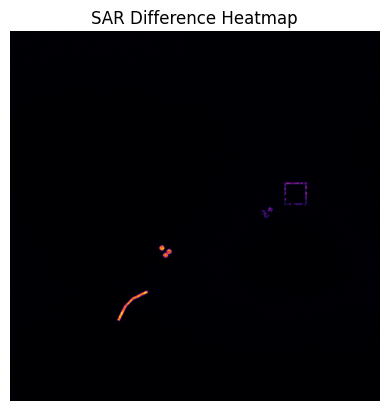

In [1]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from scipy.ndimage import gaussian_filter, label, find_objects
import matplotlib.pyplot as plt
import os

# This script analyzes Sentinel-1 SAR images from May and June 2022 to detect changes,
# creates annotated overlays on a context image, and generates a markdown intelligence report.S

# === STEP 1: Load and Normalize SAR Images ===
def load_and_preprocess(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = gaussian_filter(img, sigma=1)
    img = np.clip(img, np.percentile(img, 5), np.percentile(img, 95))
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

sar_may = load_and_preprocess("../data/satellite_images/solonytsivka_may2022_sar.png")
sar_jun = load_and_preprocess("../data/satellite_images/solonytsivka_jun2022_sar.png")

# === STEP 2: Compute Difference ===
sar_diff = cv2.absdiff(sar_jun, sar_may)

# Optional: Save heatmap
plt.imshow(sar_diff, cmap="inferno")
plt.title("SAR Difference Heatmap")
plt.axis("off")
plt.savefig("../data/output/change_maps/sar_diff_heatmap_blendonly.png")

# === STEP 3: Overlay with True/False Color ===
truecolor_path = "../data/satellite_images/solonytsivka_jun2022_truecolor.png"
falsecolor_path = "../data/satellite_images/solonytsivka_jun2022_falsecolorurban.png"

def blend_overlay(base_path, diff_map, label, out_name):
    base = cv2.imread(base_path)
    base = cv2.resize(base, (diff_map.shape[1], diff_map.shape[0]))
    diff_color = cv2.applyColorMap(diff_map, cv2.COLORMAP_INFERNO)
    blend = cv2.addWeighted(base, 0.7, diff_color, 0.6, 0)
    out_path = f"../data/output/change_maps/{out_name}"
    cv2.imwrite(out_path, blend)
    print(f"[✓] Blended overlay saved: {out_path}")
    return blend

blend_true = blend_overlay(truecolor_path, sar_diff, "True Color", "sar_overlay_truecolor.png")
blend_false = blend_overlay(falsecolor_path, sar_diff, "False Color", "sar_overlay_falsecolor.png")

# === STEP 4: Annotate Largest Change Areas ===
def annotate_diff_regions(diff_map, overlay_img, output_path):
    threshold = 40  # change sensitivity
    mask = (diff_map > threshold).astype(np.uint8)

    labeled, _ = label(mask)
    regions = find_objects(labeled)

    annotated = Image.fromarray(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)).convert("RGBA")
    draw = ImageDraw.Draw(annotated)
    annotations = []

    for i, reg in enumerate(regions):
        y1, y2 = reg[0].start, reg[0].stop
        x1, x2 = reg[1].start, reg[1].stop
        area = (x2 - x1) * (y2 - y1)
        if area < 150: continue
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 12), f"Change {i+1}", fill="red")
        annotations.append({
            "label": f"Change {i+1}",
            "x1": x1, "y1": y1, "x2": x2, "y2": y2, "area": area
        })

    annotated.save(output_path)
    print(f"[✓] Annotated image saved: {output_path}")
    return annotations

ann_true = annotate_diff_regions(sar_diff, blend_true, "../data/output/change_maps/sar_overlay_truecolor_annotated.png")
ann_false = annotate_diff_regions(sar_diff, blend_false, "../data/output/change_maps/sar_overlay_falsecolor_annotated.png")

# === STEP 5: Intelligence Report (Markdown) ===
with open("../reports/sar_blended_intel_report.md", "w") as f:
    f.write("# SAR-Based Overlay Report – Solonytsivka\n\n")
    f.write("## Summary\nSAR analysis blended with June 2022 imagery (true & false color) reveals areas of significant change.\n\n")
    f.write("Changes may indicate:\n- Track marks or movement\n- Clearing or construction\n- Ground disturbance\n\n")
    f.write("## Top Detected Changes\n\n")
    for a in sorted(ann_true, key=lambda x: -x['area'])[:5]:
        f.write(f"- **{a['label']}** — Coords: ({a['x1']}, {a['y1']}) – ({a['x2']}, {a['y2']}), Area: {a['area']} px\n")
    f.write("\n---\nGenerated via `sar_overlay_blended.py`\n")
print("[✓] Intelligence report generated: ../reports/sar_blended_intel_report.md")